In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
##### import stuff from scikit learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, recall_score, precision_score

In [2]:
facies_vector_path = 'facies_vectors.csv'
train_path = 'training_data.csv'
test_path = 'validation_data_nofacies.csv'

In [3]:
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

In [5]:
data = pd.read_csv(facies_vector_path)
X = data[feature_names].values
y= data['Facies'].values
well =data['Well Name'].values
depth = data['Depth'].values

In [6]:
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [11]:
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
data.loc[:,'FaciesLabels'] = data.apply(lambda row: label_facies(row, facies_labels), axis=1)
data.describe()

# Fitering out some outliers
j = []
for i in range(len(data)):
    if ((data['NM_M'].values[i]==2)and ((data['Facies'].values[i]==1)or(data['Facies'].values[i]==2)or(data['Facies'].values[i]==3))):
        j.append(i)
    elif((data['NM_M'].values[i]==1)and((data['Facies'].values[i]!=1)and(data['Facies'].values[i]!=2)and(data['Facies'].values[i]!=3))):
        j.append(i)

data_filtered = data.drop(data.index[j])
data_filtered


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS


In [12]:
X = data[feature_names].values

reg = RandomForestRegressor(max_features='sqrt', n_estimators=50)

DataImpAll = data[feature_names].copy()
DataImp = DataImpAll.dropna(axis = 0, inplace=False)
Ximp=DataImp.loc[:, DataImp.columns != 'PE']
Yimp=DataImp.loc[:, 'PE']
reg.fit(Ximp, Yimp)
X[np.array(DataImpAll.PE.isnull()),4] = reg.predict(DataImpAll.loc[DataImpAll.PE.isnull(),:].drop('PE',axis=1,inplace=False))

SS      268
CSiS    940
FSiS    780
SiSh    271
MS      296
WS      582
D       141
PS      686
BS      185
Name: Facies, dtype: int64

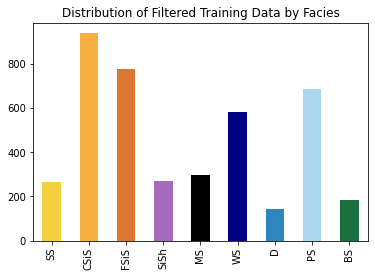

In [13]:

facies_counts = data['Facies'].value_counts().sort_index()

facies_counts.index = facies_labels


facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Filtered Training Data by Facies')


data.columns
facies_counts

In [14]:
correct_facies_labels = data['Facies'].values
feature_vectors = data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)

In [16]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
scaler = preprocessing.StandardScaler().fit(X)
scaled_features = scaler.transform(X)

In [18]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [19]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [22]:
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug

In [23]:
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

In [24]:
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [25]:
X_aug, padded_rows = augment_features(scaled_features, well, depth)
X_aug.shape

(4149, 28)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_aug, y, test_size=0.3, random_state=16)
X_train_full, X_test_zero, y_train_full, y_test_full = train_test_split(X_aug, y, test_size=0.1, random_state=16)
X_train_full.shape

(3734, 28)

In [33]:
import sklearn.svm as svm
clf_filtered = svm.SVC(C=10, gamma=1)
clf_filtered.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [35]:
predicted_labels = clf_filtered.predict(X_test)
cv_conf_svm = confusion_matrix(y_test, predicted_labels)
print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf_svm))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf_svm, adjacent_facies))


Optimized facies classification accuracy = 0.65
Optimized adjacent facies classification accuracy = 0.82


In [36]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

well_ts = well_data['Well Name'].values
depth_ts = well_data['Depth'].values
X_ts = well_data[feature_names].values
X_ts = scaler.transform(X_ts)

X_ts, padded_rows = augment_features(X_ts, well_ts, depth_ts)

In [40]:
clf_filtered = svm.SVC(C=10, gamma=1)
clf_filtered.fit(X_train_full, y_train_full)
#clf_filtered.fit(X_train_filtered, y_train_filtered)
y_pred = clf_filtered.predict(X_ts)
well_data['Facies'] = y_pred
well_data#prediction
well_data.to_csv('predict_result_svm_full_data.csv')
data# original data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS


In [41]:
well_data #prediction

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,3
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,3
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,3
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3
